# Part 1: Image captioning

In [9]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

annotations  drive  eval_v2.txt  sample_data  train2014  train_v2.txt


In [2]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

In [14]:
annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract=True)
with open(os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json', 'r') as f:
    annotations = json.load(f)

252887040/252872794 [==============================] - 6s 0us/step


In [15]:
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [16]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

train_image_paths = image_paths[:60000]
print(len(train_image_paths))

60000


In [17]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> a person laying on a bed in a room with a window <end>


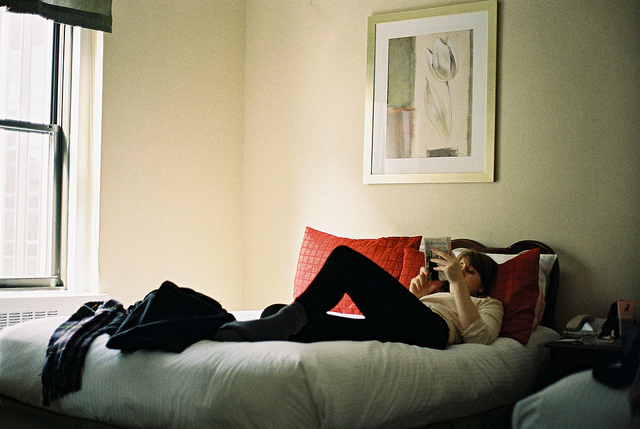

In [18]:
print(train_captions[0])
Image.open(img_name_vector[0])

In [19]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [20]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


In [21]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
from tqdm import tqdm

In [23]:
# Get unique images
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 3750/3750 [09:12<00:00,  6.79it/s]


In [25]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# Override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [26]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [27]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [28]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [29]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(240125, 240125, 60028, 60028)

In [30]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [31]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [32]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [34]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [35]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [36]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [37]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [38]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [39]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [40]:
loss_plot = []

In [41]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')

    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 1.9522
Epoch 1 Batch 100 Loss 1.0864
Epoch 1 Batch 200 Loss 0.9415
Epoch 1 Batch 300 Loss 0.8739
Epoch 1 Batch 400 Loss 0.8169
Epoch 1 Batch 500 Loss 0.7663
Epoch 1 Batch 600 Loss 0.7481
Epoch 1 Batch 700 Loss 0.7041
Epoch 1 Batch 800 Loss 0.7056
Epoch 1 Batch 900 Loss 0.7576
Epoch 1 Batch 1000 Loss 0.7367
Epoch 1 Batch 1100 Loss 0.7435
Epoch 1 Batch 1200 Loss 0.6293
Epoch 1 Batch 1300 Loss 0.6867
Epoch 1 Batch 1400 Loss 0.6708
Epoch 1 Batch 1500 Loss 0.7280
Epoch 1 Batch 1600 Loss 0.7318
Epoch 1 Batch 1700 Loss 0.7037
Epoch 1 Batch 1800 Loss 0.6697
Epoch 1 Batch 1900 Loss 0.7007
Epoch 1 Batch 2000 Loss 0.6519
Epoch 1 Batch 2100 Loss 0.7466
Epoch 1 Batch 2200 Loss 0.7315
Epoch 1 Batch 2300 Loss 0.6597
Epoch 1 Batch 2400 Loss 0.7542
Epoch 1 Batch 2500 Loss 0.6207
Epoch 1 Batch 2600 Loss 0.5971
Epoch 1 Batch 2700 Loss 0.6686
Epoch 1 Batch 2800 Loss 0.7113
Epoch 1 Batch 2900 Loss 0.6619
Epoch 1 Batch 3000 Loss 0.6009
Epoch 1 Batch 3100 Loss 0.6545
Epoch 1 Batch 3200 L

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [166]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [168]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [169]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

NameError: ignored

In [167]:
ROOT = "https://github.com/Aishwarya3011/Photos/blob/main/" 

image_url = ROOT+"Image_3.jpeg?raw=true"
image_path = tf.keras.utils.get_file(origin = image_url, cache_dir=None)

print(image_path)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

/root/.keras/datasets/Image_3.jpeg


NameError: ignored

# Part 2: Sarcasm Generation

In [1]:
!pip install happytransformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45 kB 2.1 MB/s 
     |████████████████████████████████| 346 kB 14.7 MB/s 
     |████████████████████████████████| 1.2 MB 86.2 MB/s 
     |████████████████████████████████| 4.2 MB 55.6 MB/s 
     |████████████████████████████████| 86 kB 5.5 MB/s 
     |████████████████████████████████| 212 kB 82.7 MB/s 
     |████████████████████████████████| 86 kB 4.3 MB/s 
     |████████████████████████████████| 1.1 MB 53.3 MB/s 
     |████████████████████████████████| 140 kB 54.4 MB/s 
     |████████████████████████████████| 596 kB 55.0 MB/s 
     |████████████████████████████████| 127 kB 94.0 MB/s 
     |████████████████████████████████| 6.6 MB 51.7 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 271 kB 61.3 MB/s 
     |████████████████████████████████| 144 kB 77.4 MB/s 
     |████████████████████████████████|

In [2]:
from happytransformer import HappyGeneration

In [3]:
happy_gen = HappyGeneration("GPT-NEO", "EleutherAI/gpt-neo-125M")

Downloading:   0%|          | 0.00/0.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/560 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/357 [00:00<?, ?B/s]

06/10/2022 18:57:44 - INFO - happytransformer.happy_transformer -   Using model: cuda


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
root_captioning = "/content/drive/My Drive/CS269_NLG/"

In [6]:
import numpy as np
import pandas as pd

In [27]:
import torch
import json
import os
import re

Dataset 1: Facebook Hateful Memes Dataset

In [7]:
data_dir = '/content/drive/My Drive/CS269_NLG/Facebook-Hateful-Memes_Dataset/'

img_path = data_dir + "data_dir"
train_path = data_dir + "train.jsonl"
dev_path = data_dir + "dev.jsonl"
test_path = data_dir + "test.jsonl"

In [14]:
class HatefulMemesDataset(torch.utils.data.Dataset):
    def __init__(self, data_path):
        self.data = [json.loads(l) for l in open(data_path)]
        self.data_dir = os.path.dirname(data_path)
            
    def __getitem__(self, index: int):
        # Load images on the fly.
        image = Image.open(os.path.join(self.data_dir, self.data[index]["img"])).convert("RGB")
        text = self.data[index]["text"]
        label = self.data[index]["label"]
        
        return image, text, label

    def load_image_only(self, index: int):
        image = Image.open(os.path.join(self.data_dir, self.data[index]["img"])).convert("RGB")
        return image
    
    def get_label(self, index: int):
        label = self.data[index]["label"]
        return label
    
    def get_test_item(self, index: int):
        # Load images on the fly.
        image = Image.open(os.path.join(self.data_dir, self.data[index]["img"])).convert("RGB")
        text = self.data[index]["text"]
        
        return image, text
    
    
    def __len__(self):
        return len(self.data)
train_data = HatefulMemesDataset(train_path)
val_data = HatefulMemesDataset(dev_path)
test_data = HatefulMemesDataset(test_path)

print('Data size of training data: %d samples' % len(train_data))
print('Data size of validation data: %d samples' % len(val_data))
print('Data size of test data: %d samples' % len(test_data))

Data size of training data: 8500 samples
Data size of validation data: 500 samples
Data size of test data: 1000 samples


Dataset 2: Memotion Dataset

In [15]:
df = pd.read_csv('/content/drive/My Drive/CS269_NLG/memotion_dataset_7k/labels.csv')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df = df.drop(columns = ['text_ocr'])
df.head()

,image_name,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive
1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive
2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive
3,image_4.png,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive
4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train_memotion, test_memotion = train_test_split(df, test_size = 0.2)

In [18]:
print('Data size of training data: %d samples' % len(train_memotion))
print('Data size of test data: %d samples' % len(test_memotion))

Data size of training data: 5593 samples
Data size of test data: 1399 samples


Dataset 3: Reddit Memes Dataset

In [19]:
import os, random ,cv2, glob
import keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, Activation, MaxPool2D
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import keras.preprocessing.image
import matplotlib.pyplot as plt

In [20]:
memes_path = '/content/drive/My Drive/CS269_NLG/reddit_memes_dataset/memes/memes/*'
memes = glob.glob(memes_path)

print("Memes: ",len(memes))

Memes:  3326


In [21]:
train_reddit, test_reddit = train_test_split(memes, test_size=(0.2))

In [22]:
print('Data size of training data: %d samples' % len(train_reddit))
print('Data size of test data: %d samples' % len(test_reddit))

Data size of training data: 2660 samples
Data size of test data: 666 samples


Dataset 4: News headlines

In [23]:
def format_json(file):
    with open(file,"r") as f:
        text = f.read()
    data = text.split("\n")
    
    #print(data[-50:])
    data = [json.loads(e) for e in data if e != ""]
    res = {
        "data": data
    }
    return res
    
### Get the data    
data_one = format_json("/content/drive/My Drive/CS269_NLG/Sarcasm_Detection/Sarcasm_Headlines_Dataset.json")
data_two = format_json("/content/drive/My Drive/CS269_NLG/Sarcasm_Detection/Sarcasm_Headlines_Dataset_v2.json")

In [24]:
###  Data Transformed to Data Frame 
def transform_data(data):
    data = data['data']
    keys = data[0].keys()
    
    try:
        res = {k: [d[k] for d in data] for k in keys}
        res = pd.DataFrame(res)
    except:
        print("Error the Dict Keys are inconsistent")
        print("Every dict element in the list does not have same number of keys")
        res = None
    return res

df_one = transform_data(data_one)
df_two = transform_data(data_two)

In [29]:
df_news = pd.concat([df_one,df_two],axis=0)
print(df_news.shape)

(55328, 3)


In [30]:
def clean_text(text):
    
    ### Text to lower case
    text = text.lower()
    
    ### Step 1 remove Hashtags
    pattern_one = "#[A-z0-9_\-\.#\$%]{1,}"
    text = re.sub(pattern_one,"",text)
    
    ### Step 2 Remove Mentions
    pattern_two = "@[A-z0-9_\-\.#\$%]{1,}"
    text = re.sub(pattern_two,"",text)
    
    ### Step 3 Remove Urls
    url = "https?://[A-z0-9_\-\.#\$%\?=&]+(/[A-z0-9_\-\.#\$%\?=&]+)*"
    text = re.sub(url,"",text)
    ### Step 4 remove numbers
    numbers = "\d+"
    text = re.sub(numbers,"",text)
    return text

df_news = df_news.drop("article_link",axis=1)
df_news['headline'] = df_news["headline"].apply(clean_text)

In [31]:
train_news, test_news = train_test_split(df_news,train_size=0.7,random_state=30)

print(train_news.head())

                                                headline  is_sarcastic
22054  can blind auditions change the ratio of women ...             0
17475  would you rather: max rockatansky or nux from ...             0
4592   from bulldogs to elephant walks: chats with jo...             0
10066  no, the queen isn't being shady about meghan m...             0
6006   pregame foolishly squandered on actually plann...             1


In [32]:
df_train = []
df_test = []

In [33]:
for train in train_news:
  df_train.append(train)

for train in train_reddit:
  df_train.append(train)

for train in train_memotion:
  df_train.append(train)

In [34]:
for test in test_news:
  df_test.append(test)

for test in test_reddit:
  df_test.append(test)

for test in test_memotion:
  df_test.append(test)

Dataset 5: Sarcasm_v2

In [35]:
import csv

In [36]:
collected_sarcasm_Data = []

In [37]:
file = open(root_captioning + 
            'sarcasm_v2/GEN-sarc-notsarc.csv')

csvreader = csv.reader(file)

rows = []
for row in csvreader:
        rows.append(row)

        if row[0] == 'sarc':
          collected_sarcasm_Data.append(row[2])

In [38]:
file = open(root_captioning + 
            'sarcasm_v2/HYP-sarc-notsarc.csv')

csvreader = csv.reader(file)

rows = []
for row in csvreader:
        rows.append(row)

        if row[0] == 'sarc':
          collected_sarcasm_Data.append(row[2])

In [39]:
file = open(root_captioning + 
            'sarcasm_v2/RQ-sarc-notsarc.csv')

csvreader = csv.reader(file)

rows = []
for row in csvreader:
        rows.append(row)

        if row[0] == 'sarc':
          collected_sarcasm_Data.append(row[2])

In [40]:
train_sv2, test_sv2 = train_test_split(collected_sarcasm_Data, test_size = 0.2)

In [41]:
for train in train_sv2:
  df_train.append(train)

In [42]:
for test in test_sv2:
  df_test.append(test)

In [43]:
print(len(df_train))
print(len(df_test))

6423
1614


Model Training

In [44]:
train_v2_path = "train_v2.txt"

In [45]:
eval_v2_path = "eval_v2.txt"

In [46]:
def generate_text_v2(path, dataset):
  with open(path, "w") as text_file:
    for data in dataset:     
      text_file.write(str(data))
      text_file.write("\n")

In [47]:
generate_text_v2(train_v2_path, df_train)

In [48]:
generate_text_v2(eval_v2_path, df_test)

In [49]:
result_before = happy_gen.eval(eval_v2_path)

06/10/2022 19:01:50 - INFO - happytransformer.happy_transformer -   Preprocessing dataset...


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-af3259c58f00cc15/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

06/10/2022 19:01:51 - INFO - happytransformer.happy_transformer -   Evaluating...
***** Running Evaluation *****
  Num examples = 36
  Batch size = 1


In [50]:
print("Before:", result_before.loss)

Before: 3.097564935684204


In [51]:
from happytransformer import GENSettings

In [52]:
from happytransformer import GENTrainArgs

In [53]:
train_args = GENTrainArgs(num_train_epochs=3, learning_rate=5e-5)

In [54]:
import torch
torch.cuda.empty_cache()

In [55]:
happy_gen.train(train_v2_path, args=train_args)

06/10/2022 19:02:08 - INFO - happytransformer.happy_transformer -   Preprocessing dataset...


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-c3727068ac9ccc64/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

06/10/2022 19:02:11 - INFO - happytransformer.happy_transformer -   Training...
PyTorch: setting up devices
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 141
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 423


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




In [56]:
result_after= happy_gen.eval(eval_v2_path)
result_after.loss

06/10/2022 19:05:29 - INFO - happytransformer.happy_transformer -   Preprocessing dataset...


  0%|          | 0/1 [00:00<?, ?it/s]

06/10/2022 19:05:29 - INFO - happytransformer.happy_transformer -   Evaluating...
PyTorch: setting up devices
***** Running Evaluation *****
  Num examples = 36
  Batch size = 1


2.9216089248657227

Enhanced Prediction: (sarcastic add-ons, sentiment-analysis, verb-scraping)

In [82]:
sarcastic_add_ons = [
    "Good god!",
    "What fun!",
    "I love it!",
    "I love when this happens!",
    "Just what I needed",
    "Can it get any better?",
    "God loves me truly!",
    "How great is that!"
]

In [83]:
import random

In [88]:
import spacy
import requests, json
from transformers import pipeline

In [89]:
sp = spacy.load('en_core_web_sm')

In [90]:
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")

https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp4e0n0y06


Downloading:   0%|          | 0.00/687 [00:00<?, ?B/s]

storing https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/228e83e1ade2247aebc5f0725e330fa58dedee3d9eec36c9249f25084a946130.1aece0680a18a95d51d6e1a5f83631412da37b87db65380c52052161354505ba
creating metadata file for /root/.cache/huggingface/transformers/228e83e1ade2247aebc5f0725e330fa58dedee3d9eec36c9249f25084a946130.1aece0680a18a95d51d6e1a5f83631412da37b87db65380c52052161354505ba
loading configuration file https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/228e83e1ade2247aebc5f0725e330fa58dedee3d9eec36c9249f25084a946130.1aece0680a18a95d51d6e1a5f83631412da37b87db65380c52052161354505ba
Model config RobertaConfig {
  "_name_or_path": "siebert/sentiment-roberta-large-english",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dr

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

storing https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/8fda88182b287ca423f06cae23d4c4701aaba057b65b3a691930de41e6537b3b.f135db3906a2e0c1f328a5920119f906cfb27b985cb0bfe7ef94434bdb31d031
creating metadata file for /root/.cache/huggingface/transformers/8fda88182b287ca423f06cae23d4c4701aaba057b65b3a691930de41e6537b3b.f135db3906a2e0c1f328a5920119f906cfb27b985cb0bfe7ef94434bdb31d031
loading weights file https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/8fda88182b287ca423f06cae23d4c4701aaba057b65b3a691930de41e6537b3b.f135db3906a2e0c1f328a5920119f906cfb27b985cb0bfe7ef94434bdb31d031
All model checkpoint weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the model checkpoint at siebert/sentiment-roberta-large-engl

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

storing https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/9f284be68d0cfa5298eea908fc7f51cc7e0b01c7aaf2eba99c70d938b169bfe8.ba4a40df74471cdc82cd580af48bbbcfd25e9095a9d4bb296f711f3af7e2619e
creating metadata file for /root/.cache/huggingface/transformers/9f284be68d0cfa5298eea908fc7f51cc7e0b01c7aaf2eba99c70d938b169bfe8.ba4a40df74471cdc82cd580af48bbbcfd25e9095a9d4bb296f711f3af7e2619e
loading configuration file https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/228e83e1ade2247aebc5f0725e330fa58dedee3d9eec36c9249f25084a946130.1aece0680a18a95d51d6e1a5f83631412da37b87db65380c52052161354505ba
Model config RobertaConfig {
  "_name_or_path": "siebert/sentiment-roberta-large-english",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "cla

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

storing https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/b522c6365937d6f39045d31ba715daafd39604f04b745f9d3d5cd622ecd74408.bfdcc444ff249bca1a95ca170ec350b442f81804d7df3a95a2252217574121d7
creating metadata file for /root/.cache/huggingface/transformers/b522c6365937d6f39045d31ba715daafd39604f04b745f9d3d5cd622ecd74408.bfdcc444ff249bca1a95ca170ec350b442f81804d7df3a95a2252217574121d7
https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmps538ruse


Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

storing https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/a1fbb0cbc048b898b9adb0aa928b6bde50f393786ec91ffe195736820c42b02f.f5b91da9e34259b8f4d88dbc97c740667a0e8430b96314460cdb04e86d4fc435
creating metadata file for /root/.cache/huggingface/transformers/a1fbb0cbc048b898b9adb0aa928b6bde50f393786ec91ffe195736820c42b02f.f5b91da9e34259b8f4d88dbc97c740667a0e8430b96314460cdb04e86d4fc435
https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpnwq3yap5


Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

storing https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/e7bd01a8669e2d76258ba5ab711ba48da69b2dfc573c7b02566c0e73bd4583f4.0dc5b1041f62041ebbd23b1297f2f573769d5c97d8b7c28180ec86b8f6185aa8
creating metadata file for /root/.cache/huggingface/transformers/e7bd01a8669e2d76258ba5ab711ba48da69b2dfc573c7b02566c0e73bd4583f4.0dc5b1041f62041ebbd23b1297f2f573769d5c97d8b7c28180ec86b8f6185aa8
loading file https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/b522c6365937d6f39045d31ba715daafd39604f04b745f9d3d5cd622ecd74408.bfdcc444ff249bca1a95ca170ec350b442f81804d7df3a95a2252217574121d7
loading file https://huggingface.co/siebert/sentiment-roberta-large-english/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/a1fbb0cbc048b898b9adb0aa928b6bde50f393786ec91ffe195736820c42b02f.f5b91da9e34259b8f4

# Code playground

In [137]:
caption = 'the men in dress and tie.'

In [127]:
#More sarcastic add ons to improve the negative sentiment score

def sarcastic_addition(caption):
  random.shuffle(sarcastic_add_ons)
  output = caption + '.' + sarcastic_add_ons[0] + "!"
  return output

In [128]:
#Text generated from fine-tuned gpt-neo model

def generate_text(prompt):
  result_ft = happy_gen.generate_text(prompt)
  print("Result FT: ", result_ft.text)
  return result_ft.text

def generate_text_greedy(prompt):
  greedy_settings = GENSettings(no_repeat_ngram_size=2,  max_length=50)
  result_greedy = happy_gen.generate_text(prompt, args=greedy_settings)
  print("Result Greedy: ", result_greedy.text)
  return result_greedy.text

def generate_text_generic(prompt):
  generic_sampling_settings = GENSettings(do_sample=True, top_k=0, temperature=0.5,  max_length=50, no_repeat_ngram_size=2)
  result_generic = happy_gen.generate_text(prompt, args=generic_sampling_settings)
  print("Result generic sampling: ", result_generic.text)
  return result_generic.text

def generate_text_top_k_sampling(prompt):
  top_k_sampling_settings = GENSettings(do_sample=True, top_k=15, temperature=0.5,  max_length=50, no_repeat_ngram_size=2)
  result_top_k_sampling = happy_gen.generate_text(prompt, args=top_k_sampling_settings)
  print("Result top k sampling: ", result_top_k_sampling.text)
  return result_top_k_sampling.text

In [129]:
#retain the most negative generated text

def quality_sentence_retainer(prompt, original_prompt):

  sentence_array = []
  sentiment_array= []
  sentence_array  = prompt.split('.')

  for sentence in sentence_array:
    sentiment = sentiment_analysis(sentence)
    if sentiment[0]['label'] == 'NEGATIVE':
      sentiment_array.append(sentiment[0]['score'])
      sentiment_array.append(sentence)

  current_max_score = 0
  current_quality_sentence = ""
  for i in range(0, len(sentiment_array), 2):
    if sentiment_array[i] >  current_max_score:
      current_max_score = sentiment_array[i]
      current_quality_sentence = sentiment_array[i + 1]

  return original_prompt + current_quality_sentence

In [142]:
enhanced_caption = sarcastic_addition(caption)
prompt = generate_text_greedy(enhanced_caption)
quality_sentence = quality_sentence_retainer(prompt, caption) 
print(quality_sentence)

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Result Greedy:     I'm not surprised that you are so popular.  You are a very popular person. I am surprised you don't have a lot of friends.I'm surprised I donno. You're not a fan of the "gay" movement
the men in dress and tie. You're not a fan of the "gay" movement
